In [1]:
import dp_ml
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pywt
import seaborn
from statsmodels.robust import mad
import tensorflow as tf

from ipywidgets.widgets import interactive, interact
import ipywidgets as widgets

%matplotlib inline

/Users/davidgarrett/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Macintosh detected, data path found


In [2]:
f = h5py.File(dp_ml.HDF5Path+'/'+dp_ml.HDF5Filename,'r')
t_data = f['Data/Simulation/CircWG/time']
t_names = list(t_data)
ex_t = t_data[t_names[0]]

f_data = f['Data/Simulation/CircWG/frequency']
f_names = list(f_data)
ex_f = f_data[f_names[0]]

np.shape(ex_f)


OSError: Unable to open file (unable to open file: name = '/Users/davidgarrett/Google Drive/Work/Software/machine_learning/data/dp_ml_data.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
dbFile = h5py.File(dp_ml.HDF5Path+'/'+dp_ml.HDF5Filename)
dbHier = 'Data/Simulation/CircWG'

#X_batch, y_batch = dp_ml.getBatchFromDB(dbFile,'Data/Simulation/CircWG',0, 1, freqOrTime='time',procFx=dp_ml.getMax)

X_batch_f, y_batch_f = dp_ml.getBatchFromDB(dbFile,'Data/Simulation/CircWG',0, 10, freqOrTime='frequency',procFx=dp_ml.procIdentity)


In [4]:
test = np.zeros((1,2))
test = np.transpose(test)
np.shape(test)

(2, 1)

In [4]:
np.shape(X_batch_f)

(50000, 10)

In [5]:
init, saver, loss, training_op, X_ph, y, logits = dp_ml.setupModel(n_inputs = 10,n_hidden1 = 10,n_hidden2=5, batch_size=100, activation_function = tf.nn.relu)

## Notes on the time domain maximum function

X_batch_test:
Column 1: separation distance
Column 2: time
Column 3: magnitude of dominant peak

In [6]:
X_batch_test_f , y_batch_test_f = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1200, freqOrTime='frequency', procFx = dp_ml.procIdentity)




In [7]:
np.shape(X_batch_test_f)

(6000000, 10)

In [24]:


X_batch_test , y_batch_test = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1200, freqOrTime='time', procFx = dp_ml.getMax)

#np.hstack((X_batch_test, y_batch_test))
X_same_dist = X_batch_test[X_batch_test[:,0]==10.0]
y_same_dist = y_batch_test[X_batch_test[:,0]==10.0]

epsOrSig = 0
if epsOrSig:
    eps_test = 50.0
    X_same_dist = X_same_dist[y_same_dist[:,0]==eps_test]
    y_same_dist = y_same_dist[y_same_dist[:,0]==eps_test]
else:
    sig_test = 0.0
    X_same_dist = X_same_dist[y_same_dist[:,1]==sig_test]
    y_same_dist = y_same_dist[y_same_dist[:,1]==sig_test]

plt.plot(y_same_dist[:,0],X_same_dist[:,1])
plt.ylabel('Time of arrival')
plt.xlabel('Permittivity')

plt.figure()
plt.plot(y_same_dist[:,1],X_same_dist[:,2])
plt.ylabel('Magnitude of peak')
plt.xlabel('Conductivity')

plt.figure()
plt.plot(y_same_dist[:,0],X_same_dist[:,2])
plt.ylabel('Magnitude of peak')
plt.xlabel('Permittivity')

plt.figure()
plt.plot(y_same_dist[:,1],X_same_dist[:,1])
plt.ylabel('Time of arrival')
plt.xlabel('Conductivity')

ValueError: could not broadcast input array from shape (2,1) into shape (1,2)

In [7]:
X_batch_t, y_batch_t = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1350, freqOrTime='time', procFx = dp_ml.procIdentity)
X_batch_f, y_batch_f = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1350, freqOrTime='frequency', procFx = dp_ml.procIdentity)

In [21]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

 
# Prints: [8.0, 6.0]
print("Current size: %", fig_size)

Current size: % [8, 6]


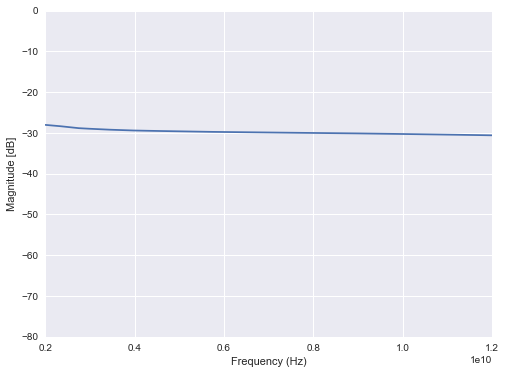

In [25]:
def plotMagPhase(eps,sig, sepDist, scale=1.0, absPlot=True, mode = 'Transmission', domain='time'):

    dbString = ''
    if domain == 'time':
        X_batch = X_batch_t
        y_batch = y_batch_t
        scaleFactor = 1e9
        xlabel = 'Time (s)'
    elif domain =='frequency':
        X_batch = X_batch_f
        y_batch = y_batch_t
        scaleFactor = 1
        xlabel = 'Frequency (Hz)'
        
    X_eps = X_batch[y_batch[:,0]==eps,:]
    y_eps = y_batch[y_batch[:,0]==eps,:]
    
    X_epssig = X_eps[y_eps[:,1]==sig]
    y_epssig = y_eps[y_eps[:,1]==sig]
    
    X_epssigdist = X_epssig[X_epssig[:,0]==sepDist]
    y_epssigdist = y_epssig[X_epssig[:,0]==sepDist]
    
    #plt.plot(dp_ml.mag2db(X_epssigdist[:,4]))
    if mode == 'transmission':
        if domain == 'time':
            ind = 3
        elif domain =='frequency':
            ind = 4
    elif mode == 'reflection':
        ind = 2
        
    if absPlot:
        if domain == 'time':
            plt.plot(X_epssigdist[:,1],np.absolute(X_epssigdist[:,ind]))
            plt.ylim([0,scale*scaleFactor])
        elif domain == 'frequency':
            plt.plot(X_epssigdist[:,1],dp_ml.mag2db(X_epssigdist[:,ind]))
            plt.ylim([-80,0])
            dbString = '[dB]'
        plt.xlabel(xlabel)
    else:
        if domain == 'time':
            plt.plot(X_epssigdist[:,1],(X_epssigdist[:,ind]))
            plt.ylim([-scale*scaleFactor,scale*scaleFactor])
        elif domain == 'frequency':
            plt.plot(X_epssigdist[:,1],np.absolute(X_epssigdist[:,ind]))
            plt.ylim([0,scale*scaleFactor])
        plt.xlabel(xlabel)
    plt.xlim([X_epssigdist[0,1], X_epssigdist[-1,1]])
    plt.ylabel('Magnitude ' + dbString)
    
#X_batch, y_batch = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1200, freqOrTime='frequency', procFx = dp_ml.procIdentity)
#np.shape(y_batch)  
#np.shape(y_batch[:,0]==10)

interact(plotMagPhase,eps=widgets.IntSlider(min=2,max=70,step=2,value=26),
         sig=widgets.IntSlider(min=0,max=10,step=1,value=2),sepDist=widgets.IntSlider(min=10,max=50,step=10,value=30), 
         scale=widgets.FloatSlider(min=0.1,max=5.0,step=0.1,value=1.0, absPlot=True), 
         mode=['transmission','reflection'], domain = ['time', 'frequency']);

In [23]:
#dp_ml.runModel(dp_ml.HDF5Path+'/'+dp_ml.HDF5Filename, 'Data/Simulation/CircWG', init, saver, loss, training_op, X_ph, y, procFx = dp_ml.getMax, freqOrTime = 'time',batch_size = 40, n_epochs = 100)
dp_ml.runModel(dp_ml.HDF5Path+'/'+dp_ml.HDF5Filename, 'Data/Simulation/CircWG', init, saver, loss, training_op, X_ph, y, procFx = dp_ml.procIdentity, freqOrTime = 'frequency',batch_size = 1, n_epochs = 100)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


KeyboardInterrupt: 

In [ ]:
model_name = './Models/ANN_model_20171103-152159_100-epochs_.ckpt'

dp_ml.predictFromModel(model_name, X_batch, saver, logits, X_ph)

In [ ]:
[X_batch, y_batch]

In [ ]:
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots()
    plt.plot( x, color="b", alpha=0.5 )
    plt.plot( y, color="b" )
    if title:
        plt.set_title(title)
    plt.xlim((0,len(y)))